In [21]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

print("--- [สร้างฐานข้อมูล] ---")

full_csv_filename = 'GlobalFoodPricesFull.csv'
db_filename = 'global_food_prices.db'
table_name = 'food_prices'

try:
    print(f"กำลังอ่านไฟล์ CSV ขนาดใหญ่: {full_csv_filename}...")
    df_full = pd.read_csv(full_csv_filename, low_memory=False)
    
    print(f"อ่านไฟล์สำเร็จ มี {len(df_full)} แถว")
    
    engine = create_engine(f'sqlite:///{db_filename}')
    
    print(f"กำลังเขียนข้อมูลลงตาราง '{table_name}' ในฐานข้อมูล '{db_filename}'...")
    df_full.to_sql(table_name, engine, index=False, if_exists='replace')
    
    print(f"สร้างตาราง '{table_name}' สำเร็จ!")
    
except FileNotFoundError:
    print(f"!!! ข้อผิดพลาด: ไม่พบไฟล์ '{full_csv_filename}'")
except Exception as e:
    print(f"เกิดข้อผิดพลาดระหว่างสร้างฐานข้อมูล: {e}")

--- [สร้างฐานข้อมูล] ---
กำลังอ่านไฟล์ CSV ขนาดใหญ่: GlobalFoodPricesFull.csv...
อ่านไฟล์สำเร็จ มี 3109617 แถว
กำลังเขียนข้อมูลลงตาราง 'food_prices' ในฐานข้อมูล 'global_food_prices.db'...
สร้างตาราง 'food_prices' สำเร็จ!


In [22]:
import pandas as pd
import sqlite3
import numpy as np
import warnings

warnings.filterwarnings('ignore')

print("--- [ขั้นตอนที่ 1 & 2] (ฉบับใหม่: กรองเฉพาะ 'Wheat flour') ---")

db_filename = 'global_food_prices.db'
table_name = 'food_prices'

commodity_to_analyze = 'Wheat flour'

query = f"""
    SELECT 
        date, 
        country_code, 
        market, 
        commodity, 
        price_usd,
        category,
        unit,
        latitude,  
        longitude  
    FROM {table_name}
    WHERE 
        price_type = 'Retail' 
        AND commodity = '{commodity_to_analyze}'
        AND price_flag = 'actual'
"""

print(f"กำลังเชื่อมต่อกับ '{db_filename}' และดึงข้อมูลเฉพาะ '{commodity_to_analyze}'...")

try:
    conn = sqlite3.connect(db_filename)
    df = pd.read_sql(query, conn) 
    conn.close()
    
    print(f"ดึงข้อมูลสำเร็จ! ได้ข้อมูลมา {len(df)} แถว")

    rows_before = len(df)
    df.dropna(inplace=True) 
    rows_after = len(df)
    print(f"[Pre-processing 1] ลบแถวที่มี 'ค่าว่าง' (NaN) ทั้งหมด: ลบไป {rows_before - rows_after} แถว")

    df['date'] = pd.to_datetime(df['date'])
    print("[Pre-processing 2] แปลงคอลัมน์ 'date' เป็นชนิด datetime สำเร็จ")

    print("\n--- ข้อมูล 'หลัง' การทำความสะอาด (พร้อมใช้งาน) ---")
    print(df.info())
    print("\n--- ตรวจสอบสินค้า (Wheat flour) ---")
    print(f"สินค้าทั้งหมดที่ดึงมา: {df['commodity'].nunique()} ชนิด")
    print(df['commodity'].unique())


except Exception as e:
    print(f"!!! เกิดข้อผิดพลาด: {e}")

--- [ขั้นตอนที่ 1 & 2] (ฉบับใหม่: กรองเฉพาะ 'Wheat flour') ---
กำลังเชื่อมต่อกับ 'global_food_prices.db' และดึงข้อมูลเฉพาะ 'Wheat flour'...
ดึงข้อมูลสำเร็จ! ได้ข้อมูลมา 46887 แถว
[Pre-processing 1] ลบแถวที่มี 'ค่าว่าง' (NaN) ทั้งหมด: ลบไป 698 แถว
[Pre-processing 2] แปลงคอลัมน์ 'date' เป็นชนิด datetime สำเร็จ

--- ข้อมูล 'หลัง' การทำความสะอาด (พร้อมใช้งาน) ---
<class 'pandas.core.frame.DataFrame'>
Index: 46189 entries, 0 to 46886
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          46189 non-null  datetime64[ns]
 1   country_code  46189 non-null  object        
 2   market        46189 non-null  object        
 3   commodity     46189 non-null  object        
 4   price_usd     46189 non-null  float64       
 5   category      46189 non-null  object        
 6   unit          46189 non-null  object        
 7   latitude      46189 non-null  float64       
 8   longitude     46189 non-null  

In [60]:
import re  

print("\n--- [ขั้นตอนที่ 2.5] เริ่มการแปลงหน่วย (Unit Normalization) ---")

try:
    print("ตรวจสอบค่า 'unit' ที่มีในข้อมูล 'Wheat flour':")
    print(df['unit'].unique())

    def get_kg_multiplier(unit_str):
        unit_str = str(unit_str).upper()
        
        unit_str = re.sub(r'\s+', '', unit_str)
        
        if unit_str == 'KG' or unit_str == '1KG':
            return 1.0
        
        if 'G' in unit_str and 'KG' not in unit_str:
            value = re.findall(r"[\d\.]+", unit_str)
            if value:
                return float(value[0]) / 1000.0
        
        if 'KG' in unit_str:
            value = re.findall(r"[\d\.]+", unit_str)
            if value:
                return float(value[0])
                
        return None

    df['kg_multiplier'] = df['unit'].apply(get_kg_multiplier)
    
    rows_before = len(df)
    df.dropna(subset=['kg_multiplier'], inplace=True)
    
    rows_after = len(df)
    print(f"[Normalization 1] ลบแถวที่ไม่สามารถแปลงหน่วย (kg_multiplier) ได้: ลบไป {rows_before - rows_after} แถว")

    df['price_per_kg'] = df['price_usd'] / df['kg_multiplier']
    
    print("[Normalization 2] สร้างคอลัมน์ 'price_per_kg' สำเร็จ!")
    
    print("\n--- ตัวอย่างข้อมูลหลังการ Normalization ---")
    print(df[['unit', 'price_usd', 'kg_multiplier', 'price_per_kg']].sample(500))

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการแปลงหน่วย: {e}")


--- [ขั้นตอนที่ 2.5] เริ่มการแปลงหน่วย (Unit Normalization) ---
ตรวจสอบค่า 'unit' ที่มีในข้อมูล 'Wheat flour':
['KG' '100 KG' '50 KG' '12.5 KG' '1.5 KG' '60 KG' '900 G']
[Normalization 1] ลบแถวที่ไม่สามารถแปลงหน่วย (kg_multiplier) ได้: ลบไป 0 แถว
[Normalization 2] สร้างคอลัมน์ 'price_per_kg' สำเร็จ!

--- ตัวอย่างข้อมูลหลังการ Normalization ---
          unit  price_usd  kg_multiplier  price_per_kg
5803        KG       1.36            1.0        1.3600
29119       KG       0.46            1.0        0.4600
37691       KG       0.60            1.0        0.6000
25072       KG       0.49            1.0        0.4900
35617       KG       0.87            1.0        0.8700
...        ...        ...            ...           ...
43636   100 KG      74.14          100.0        0.7414
16073  12.5 KG       6.61           12.5        0.5288
30840       KG       0.83            1.0        0.8300
31414       KG       0.29            1.0        0.2900
44356       KG       0.84            1.0        

In [24]:
print("\n--- [ขั้นตอนที่ 3] เริ่มต้นการทำ Feature Engineering ---")

import re 

try:

    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Quarter'] = df['date'].dt.quarter
    print("[Feature Eng. 1] สร้างตัวแปร Year, Month, Quarter สำเร็จ")

    features_to_encode = ['country_code'] 
    # ------------------------
    
    print(f"[Feature Eng. 2] กำลังแปลง {features_to_encode} ด้วย One-Hot Encoding...")
    
    df_encoded = pd.get_dummies(df, columns=features_to_encode, drop_first=True)
    print("[Feature Eng. 2] แปลง One-Hot Encoding สำเร็จ")

    y = df_encoded['price_per_kg']
    
    X = df_encoded.drop(columns=[
        'date',
        'market',
        'price_usd',
        'commodity', 
        'category',
        'unit',           
        'kg_multiplier',  
        'price_per_kg'    
    ])
    
    print("[Feature Eng. 3] กำลังล้าง (Sanitize) ชื่อคอลัมน์สำหรับ LightGBM...")
    
    X.columns = [re.sub(r'[\\[\\]()<,]', '_', col) for col in X.columns]
    
    print("[Feature Eng. 3] ล้างชื่อคอลัมน์สำเร็จ!")

    print("\n--- Feature Engineering เสร็จสิ้น! ---")
    print("โครงสร้าง Features (X) ทั้งหมด:")
    X.info()

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างทำ Feature Engineering: {e}")


--- [ขั้นตอนที่ 3] เริ่มต้นการทำ Feature Engineering ---
[Feature Eng. 1] สร้างตัวแปร Year, Month, Quarter สำเร็จ
[Feature Eng. 2] กำลังแปลง ['country_code'] ด้วย One-Hot Encoding...
[Feature Eng. 2] แปลง One-Hot Encoding สำเร็จ
[Feature Eng. 3] กำลังล้าง (Sanitize) ชื่อคอลัมน์สำหรับ LightGBM...
[Feature Eng. 3] ล้างชื่อคอลัมน์สำเร็จ!

--- Feature Engineering เสร็จสิ้น! ---
โครงสร้าง Features (X) ทั้งหมด:
<class 'pandas.core.frame.DataFrame'>
Index: 46189 entries, 0 to 46886
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   latitude          46189 non-null  float64
 1   longitude         46189 non-null  float64
 2   Year              46189 non-null  int32  
 3   Month             46189 non-null  int32  
 4   Quarter           46189 non-null  int32  
 5   country_code_ARG  46189 non-null  bool   
 6   country_code_ARM  46189 non-null  bool   
 7   country_code_BGD  46189 non-null  bool   
 8   country_cod

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

print("\n--- [ขั้นตอนที่ 4] (ฉบับอัปเกรด: ทดลอง 5 โมเดล) ---")

try:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"แบ่งข้อมูล: {len(X_train)} แถวสำหรับ Train, {len(X_test)} แถวสำหรับ Test")

    models = {
        "1. Linear Regression": LinearRegression(),
        "2. Ridge Regression": Ridge(random_state=42),
        "3. Decision Tree": DecisionTreeRegressor(random_state=42),
        "4. Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "5. LightGBM (LGBM)": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    }

    model_names = []
    r2_scores = []
    mae_scores = []

    for name, model in models.items():
        print(f"\nกำลังเทรนโมเดล: {name}...")
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        model_names.append(name)
        r2_scores.append(r2)
        mae_scores.append(mae)
        
        print(f"ผลลัพธ์ {name}: R-squared = {r2:.4f}, MAE = {mae:.4f}")

    print("\n--- ตารางเปรียบเทียบประสิทธิภาพโมเดล (Scoreboard) ---")
    
    scoreboard = pd.DataFrame({
        'Algorithm': model_names,
        'R-squared': r2_scores,
        'Mean Absolute Error (MAE)': mae_scores
    })
    
    scoreboard_sorted = scoreboard.sort_values(by='R-squared', ascending=False)
    
    print(scoreboard_sorted)
    
    print("\n--- [Dynamic] การบันทึกผลลัพธ์ Baseline อัตโนมัติ ---")
    
    best_model_row = scoreboard_sorted.iloc[0]
    
    best_model_name = best_model_row['Algorithm']
    baseline_r2 = best_model_row['R-squared']
    baseline_mae = best_model_row['Mean Absolute Error (MAE)']
    
    print(f"โมเดลที่ดีที่สุดคือ: {best_model_name}")
    print(f"กำลังส่งค่า R2={baseline_r2:.4f}, MAE={baseline_mae:.4f} ไปยังขั้นตอนที่ 5...")

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการเทรนโมเดล: {e}")


--- [ขั้นตอนที่ 4] (ฉบับอัปเกรด: ทดลอง 5 โมเดล) ---
แบ่งข้อมูล: 36951 แถวสำหรับ Train, 9238 แถวสำหรับ Test

กำลังเทรนโมเดล: 1. Linear Regression...
ผลลัพธ์ 1. Linear Regression: R-squared = 0.5967, MAE = 0.4015

กำลังเทรนโมเดล: 2. Ridge Regression...
ผลลัพธ์ 2. Ridge Regression: R-squared = 0.5963, MAE = 0.4031

กำลังเทรนโมเดล: 3. Decision Tree...
ผลลัพธ์ 3. Decision Tree: R-squared = 0.8222, MAE = 0.1275

กำลังเทรนโมเดล: 4. Random Forest...
ผลลัพธ์ 4. Random Forest: R-squared = 0.8679, MAE = 0.1164

กำลังเทรนโมเดล: 5. LightGBM (LGBM)...
ผลลัพธ์ 5. LightGBM (LGBM): R-squared = 0.9077, MAE = 0.1774

--- ตารางเปรียบเทียบประสิทธิภาพโมเดล (Scoreboard) ---
              Algorithm  R-squared  Mean Absolute Error (MAE)
4    5. LightGBM (LGBM)   0.907711                   0.177387
3      4. Random Forest   0.867890                   0.116369
2      3. Decision Tree   0.822163                   0.127521
0  1. Linear Regression   0.596686                   0.401518
1   2. Ridge Regression   0.5

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


print("\n--- [ขั้นตอนที่ 5] เริ่มต้นการปรับปรุงพารามิเตอร์ (Fine-tuning) (ฉบับแก้ไข: จูนทุกโมเดล โดยเน้น R-squared) ---")
try:
    _ = X_train
    _ = y_train
    _ = X_test
    _ = y_test
    _ = scoreboard_sorted 
    print(f"พบข้อมูล Train/Test และ Scoreboard จากขั้นตอนที่ 4")
except NameError:
    print("!!! ไม่พบตัวแปร (เช่น X_train, y_train, scoreboard_sorted) !!!")
    print("!!! กรุณารัน Cell ที่ 4 (ขั้นตอนที่ 4) ก่อน!!!")
    raise

estimator_blueprints = {
    "1. Linear Regression": LinearRegression(),
    "2. Ridge Regression": Ridge(random_state=42),
    "3. Decision Tree": DecisionTreeRegressor(random_state=42),
    "4. Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "5. LightGBM (LGBM)": lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1) 
}

param_grids = {
    "1. Linear Regression": {}, 
    "2. Ridge Regression": {
        'alpha': [0.5, 1.0, 5.0] 
    },
    "3. Decision Tree": {
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 5, 10]
    },
    "4. Random Forest": {
        'n_estimators': [100, 200], 
        'max_depth': [10, 20, None]
    },
    "5. LightGBM (LGBM)": {
        'num_leaves': [31, 50],
        'n_estimators': [100, 200]
    }
}


tuned_results = []
best_estimators_map = {}

print("...กำลังประมวลผล GridSearchCV สำหรับ 5 โมเดล (อาจใช้เวลาสักครู่)...")

for name, estimator in estimator_blueprints.items():
    
    baseline_row = scoreboard_sorted[scoreboard_sorted['Algorithm'] == name].iloc[0]
    baseline_r2 = baseline_row['R-squared']
    baseline_mae = baseline_row['Mean Absolute Error (MAE)'] 

    param_grid = param_grids[name]

    if not param_grid:
        estimator.fit(X_train, y_train) 
        tuned_model = estimator
        tuned_r2 = baseline_r2
        tuned_mae = baseline_mae
        
    else:
        grid_search = GridSearchCV(
            estimator=estimator, 
            param_grid=param_grid, 
            cv=3, 
            scoring='r2', 
            n_jobs=-1,
            verbose=0 
        )
        grid_search.fit(X_train, y_train)
        
        tuned_model = grid_search.best_estimator_
        
        y_pred_tuned = tuned_model.predict(X_test)
        tuned_r2 = r2_score(y_test, y_pred_tuned)
        tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

    tuned_results.append({
        'Algorithm': name,
        'Baseline R-squared': baseline_r2, 
        'Tuned R-squared': tuned_r2,
        'Tuned MAE': tuned_mae, 
        'Baseline MAE': baseline_mae 
    })
    best_estimators_map[name] = tuned_model

print("...ประมวลผลเสร็จสิ้น!")

print("\n\n--- [ขั้นตอนที่ 5] สรุปผลการ Fine-tuning ทั้งหมด ---")
tuned_scoreboard = pd.DataFrame(tuned_results)

tuned_scoreboard['R-squared Improvement (%)'] = ((tuned_scoreboard['Tuned R-squared'] - tuned_scoreboard['Baseline R-squared']) / tuned_scoreboard['Baseline R-squared'].abs().replace(0, 1e-6)) * 100

tuned_scoreboard_sorted = tuned_scoreboard.sort_values(by='Tuned R-squared', ascending=False)

print("--- ตารางเปรียบเทียบประสิทธิภาพ (หลัง Fine-tuning) (เรียงตาม R-squared ที่ดีที่สุด) ---")

print(tuned_scoreboard_sorted[[
    'Algorithm', 
    'Tuned R-squared',
    'Baseline R-squared',       
    'R-squared Improvement (%)',
    'Tuned MAE',
    'Baseline MAE'  
]])

best_tuned_row = tuned_scoreboard_sorted.iloc[0]
best_tuned_name = best_tuned_row['Algorithm']
best_tuned_mae = best_tuned_row['Tuned MAE'] 

best_tuned_model = best_estimators_map[best_tuned_name] 

print(f"\n--- โมเดลที่ดีที่สุด (หลัง Fine-tuning) ---")
print(f"โมเดล: {best_tuned_name} (R-squared: {best_tuned_row['Tuned R-squared']:.4f}, MAE: {best_tuned_mae:.4f})")
print("กำลังบันทึกโมเดลนี้เป็น 'best_tuned_model' เพื่อใช้ในขั้นตอนที่ 8...")

warnings.filterwarnings('default', category=UserWarning)
warnings.filterwarnings('default', category=FutureWarning)


--- [ขั้นตอนที่ 5] เริ่มต้นการปรับปรุงพารามิเตอร์ (Fine-tuning) (ฉบับแก้ไข: จูนทุกโมเดล โดยเน้น R-squared) ---
พบข้อมูล Train/Test และ Scoreboard จากขั้นตอนที่ 4
...กำลังประมวลผล GridSearchCV สำหรับ 5 โมเดล (อาจใช้เวลาสักครู่)...
...ประมวลผลเสร็จสิ้น!


--- [ขั้นตอนที่ 5] สรุปผลการ Fine-tuning ทั้งหมด ---
--- ตารางเปรียบเทียบประสิทธิภาพ (หลัง Fine-tuning) (เรียงตาม R-squared ที่ดีที่สุด) ---
              Algorithm  Tuned R-squared  Baseline R-squared  \
4    5. LightGBM (LGBM)         0.891452            0.907711   
2      3. Decision Tree         0.886179            0.822163   
3      4. Random Forest         0.880534            0.867890   
0  1. Linear Regression         0.596686            0.596686   
1   2. Ridge Regression         0.596547            0.596346   

   R-squared Improvement (%)  Tuned MAE  Baseline MAE  
4                  -1.791177   0.163184      0.177387  
2                   7.786400   0.237130      0.127521  
3                   1.456844   0.229943      0.1163


--- [ขั้นตอนที่ 6] เริ่มต้นการวิเคราะห์และสร้างกราฟ (Visualization) ---
กำลังสร้าง กราฟที่ 1: แนวโน้มราคาระยะยาว (Line Plot)


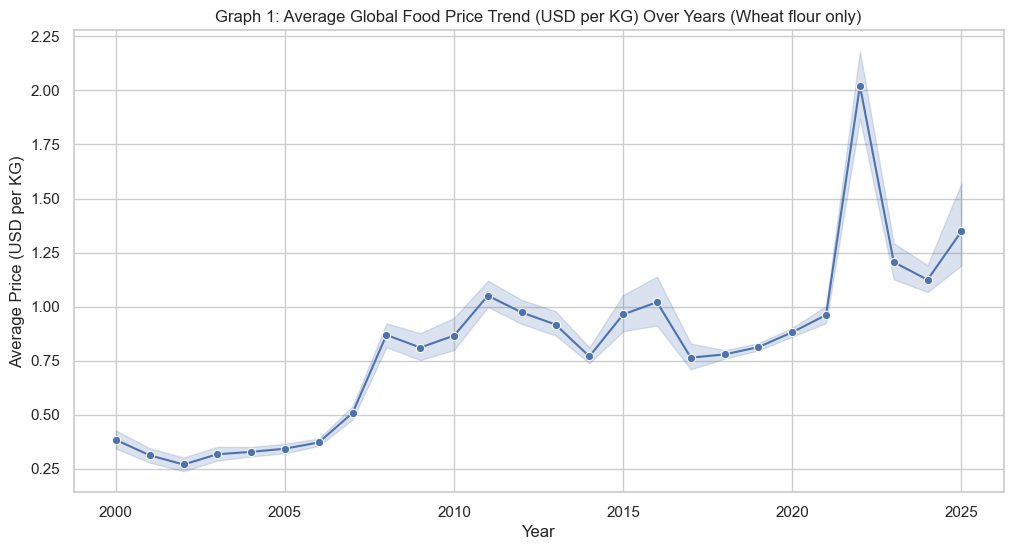


กำลังสร้าง กราฟที่ 2: การกระจายตัวของราคา (Box Plot) [แบบซ่อน Outliers]


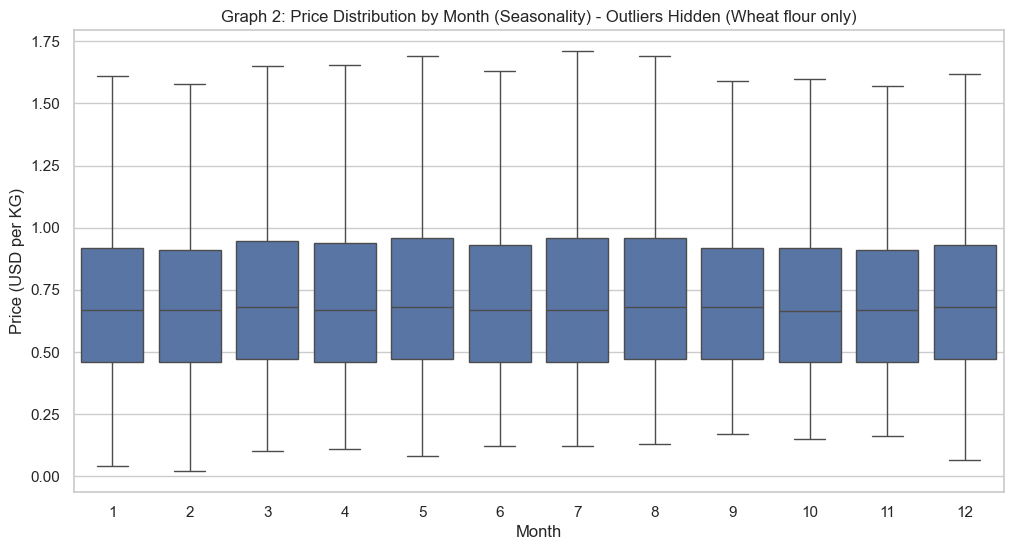


กำลังสร้าง กราฟที่ 3: 10 ประเทศที่มีราคาเฉลี่ยสูงสุด (Bar Plot)


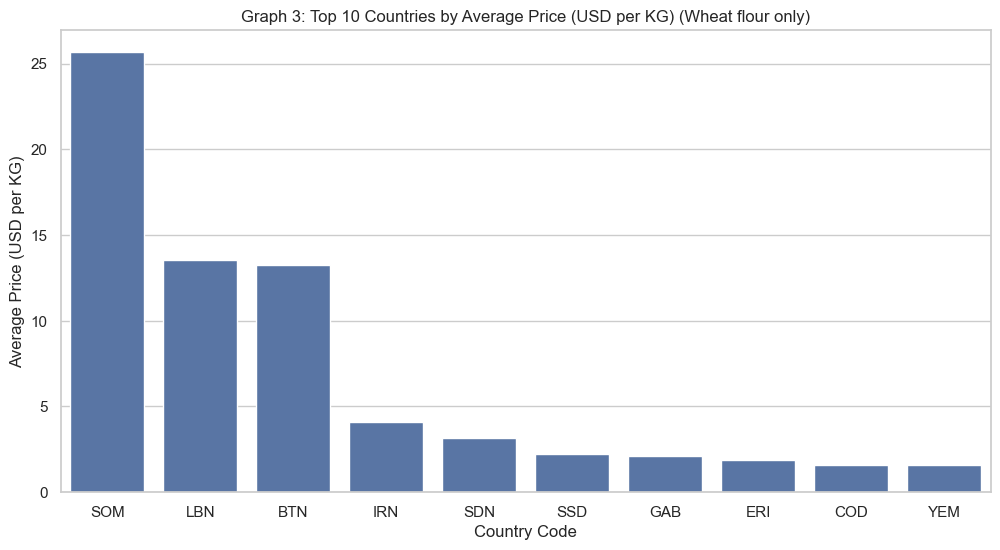

แปลง Country Code เป็นทวีปสำเร็จ!


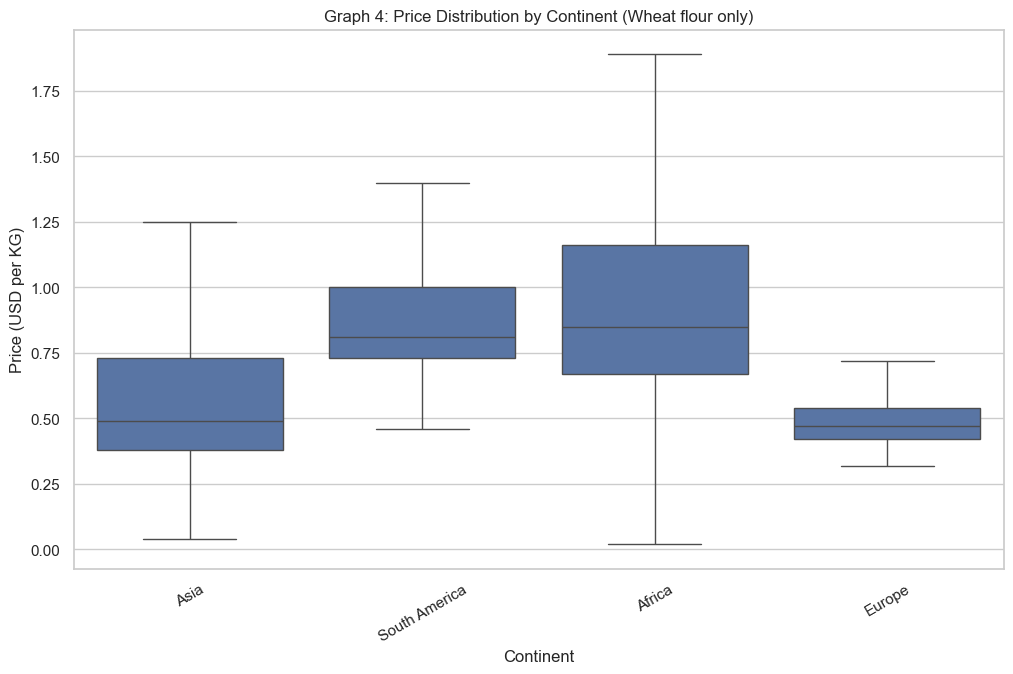

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import pycountry_convert
import warnings

print("\n--- [ขั้นตอนที่ 6] เริ่มต้นการวิเคราะห์และสร้างกราฟ (Visualization) ---")

sns.set_theme(style="whitegrid")

def country_code_to_continent(country_code_3):
    if country_code_3 == 'SSD': return 'Africa' # รหัส South Sudan (SSD) ไม่มีในบาง library
    if country_code_3 == 'PSE': return 'Asia'   # รหัส Palestine (PSE)
    
    try:
        # แปลง ISO3 (เช่น 'ARG') เป็น ISO2 (เช่น 'AR')
        country_code_2 = pycountry.countries.get(alpha_3=country_code_3).alpha_2
        # แปลง ISO2 เป็น รหัสทวีป (เช่น 'SA')
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_code_2)
        # แปลงรหัสทวีป เป็น ชื่อทวีป (เช่น 'South America')
        continent_name = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except Exception as e:
        return 'Other' # ถ้าหาไม่เจอ ให้เป็น 'Other'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['continent'] = df['country_code'].apply(country_code_to_continent)

try:
    print("กำลังสร้าง กราฟที่ 1: แนวโน้มราคาระยะยาว (Line Plot)")
    
    df_yearly_price = df.groupby('Year')['price_per_kg'].mean().reset_index()
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    
    sns.lineplot(data=df, x='Year', y='price_per_kg', marker='o', ax=ax1)
    
    ax1.set_title('Graph 1: Average Global Food Price Trend (USD per KG) Over Years (Wheat flour only)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Price (USD per KG)')
    plt.show()
    
    print("\nกำลังสร้าง กราฟที่ 2: การกระจายตัวของราคา (Box Plot) [แบบซ่อน Outliers]")
    
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df, x='Month', y='price_per_kg', showfliers=False, ax=ax3) 
    
    ax3.set_title('Graph 2: Price Distribution by Month (Seasonality) - Outliers Hidden (Wheat flour only)')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Price (USD per KG)')
    plt.show()

    print("\nกำลังสร้าง กราฟที่ 3: 10 ประเทศที่มีราคาเฉลี่ยสูงสุด (Bar Plot)")
    
    df_country_avg = df.groupby('country_code')['price_per_kg'].mean().reset_index()
    
    df_top10 = df_country_avg.nlargest(10, 'price_per_kg')

    fig4, ax4 = plt.subplots(figsize=(12, 6))
    
    sns.barplot(data=df_top10, 
                x='country_code', 
                y='price_per_kg', 
                ax=ax4, 
                order=df_top10['country_code'])
    
    ax4.set_title('Graph 3: Top 10 Countries by Average Price (USD per KG) (Wheat flour only)')
    ax4.set_xlabel('Country Code')
    ax4.set_ylabel('Average Price (USD per KG)')
    plt.show()

    print("แปลง Country Code เป็นทวีปสำเร็จ!")

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.boxplot(data=df, 
                x='continent', 
                y='price_per_kg', 
                showfliers=False,
                ax=ax)

    ax.set_title('Graph 4: Price Distribution by Continent (Wheat flour only)')
    ax.set_xlabel('Continent')
    ax.set_ylabel('Price (USD per KG)')
    plt.xticks(rotation=30)
    plt.show()

    

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการสร้างกราฟ: {e}")
    print("!!! กรุณาตรวจสอบว่า DataFrame 'df' ยังอยู่ใน Memory (ได้รัน Cell 1-2.5 แล้ว)")


--- [ขั้นตอนที่ 8] การสร้างกราฟทำนายอนาคต (ฉบับแก้ไข: ค่าเฉลี่ยรายปี) ---
กำลังเตรียมทำนายอนาคตของ: Wheat flour (เฉลี่ยรายปี) ... 5 ปีล่วงหน้า


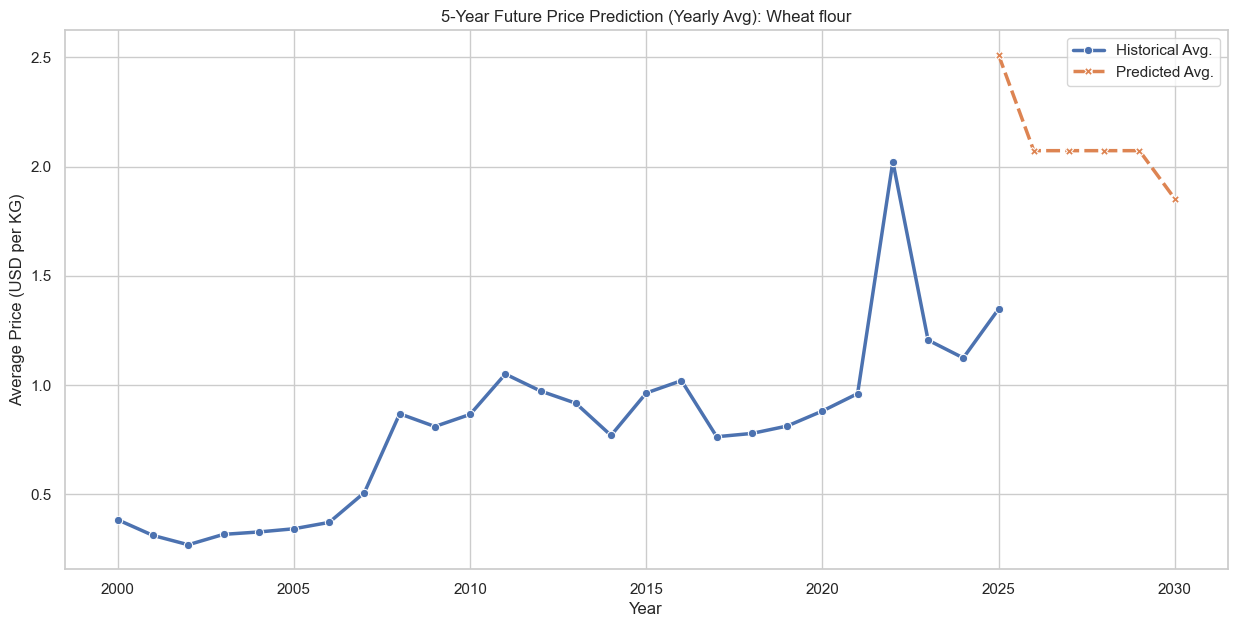

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

print("\n--- [ขั้นตอนที่ 8] การสร้างกราฟทำนายอนาคต (ฉบับแก้ไข: ค่าเฉลี่ยรายปี) ---")

commodity_to_predict = 'Wheat flour'

print(f"กำลังเตรียมทำนายอนาคตของ: {commodity_to_predict} (เฉลี่ยรายปี) ... 5 ปีล่วงหน้า")

try:
    last_date = df['date'].max()
    future_periods = 60 
    future_dates = pd.date_range(start=last_date, periods=future_periods, freq='MS') 
    
    df_future = pd.DataFrame(0, index=future_dates, columns=X.columns)
    
    df_future['Year'] = df_future.index.year 
    df_future['Month'] = df_future.index.month
    df_future['Quarter'] = df_future.index.quarter
    
    future_predictions = best_tuned_model.predict(df_future)
    
    df_predictions_monthly = pd.DataFrame({
        'date': future_dates,
        'predicted_price_per_kg': future_predictions 
    })
    
    df_predictions_monthly['Year'] = df_predictions_monthly['date'].dt.year
    df_predictions_yearly = df_predictions_monthly.groupby('Year')['predicted_price_per_kg'].mean().reset_index()
    
    df_historical = df[df['commodity'] == commodity_to_predict]
    df_historical['Year'] = df_historical['date'].dt.year 
    df_historical_yearly = df_historical.groupby('Year')['price_per_kg'].mean().reset_index()

    df_hist_plot = df_historical_yearly.rename(columns={'price_per_kg': 'Price (USD per KG)'})
    df_hist_plot['Type'] = 'Historical Avg.'

    df_pred_plot = df_predictions_yearly.rename(columns={'predicted_price_per_kg': 'Price (USD per KG)'})
    df_pred_plot['Type'] = 'Predicted Avg.'

    df_combined_plot = pd.concat([df_hist_plot, df_pred_plot])
 
    fig, ax = plt.subplots(figsize=(15, 7))
    
    sns.lineplot(data=df_combined_plot, 
                 x='Year', 
                 y='Price (USD per KG)', 
                 hue='Type', 
                 style='Type', 
                 markers=True, 
                 dashes=True, 
                 ax=ax,
                 linewidth=2.5)
    
    ax.set_title(f'5-Year Future Price Prediction (Yearly Avg): {commodity_to_predict}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Price (USD per KG)')
    
    ax.legend()
    plt.show()

except NameError as e:
    print(f"!!! Error: ไม่พบตัวแปร (เช่น 'X' หรือ 'best_tuned_model')")
    print("!!! กรุณารัน Cell 1-5 ให้ครบก่อน!!!")
except Exception as e:
    print(f"เกิดข้อผิดพลาด: {e}")